In [35]:
!pip install --upgrade xgboost

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)


In [47]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier, plot_importance, XGBRegressor

In [37]:
df = pd.read_csv('features_j.csv')
df['outage_occurred'] = (df['customers_out'] > 0).astype(int)
print(df['outage_occurred'].value_counts())

outage_occurred
1    21673
0    13442
Name: count, dtype: int64


In [38]:
categorical_cols = ['event_type_num', 'begin_weekday', 'begin_month', 'FIPS']

X = df.drop(columns=['customers_out', 'outage_occurred'])
y = df['outage_occurred']

# Set correct dtypes
for col in categorical_cols:
    X[col] = X[col].astype('category')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = XGBClassifier(
    tree_method='hist',              # Required for categorical support
    enable_categorical=True,         # Enables native handling
    use_label_encoder=False,         # Avoids legacy warning
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

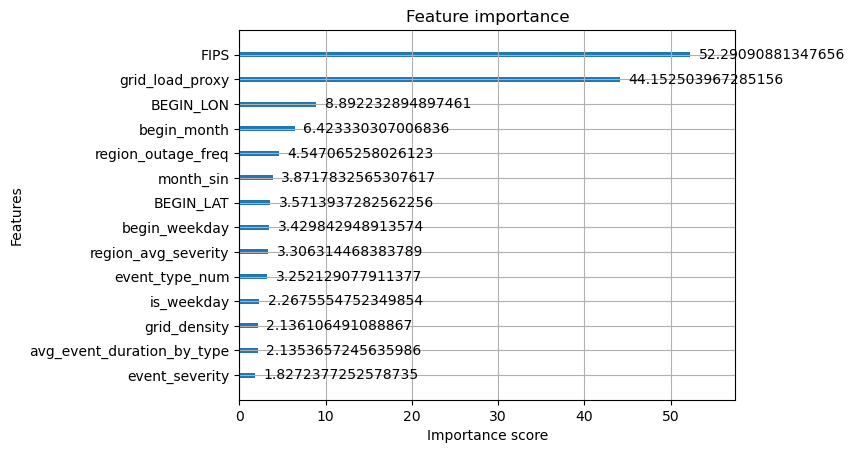

In [46]:
plot_importance(model, max_num_features=20, importance_type='gain')  # or 'weight', 'cover'
plt.show()

In [48]:
df_reg = df[df['outage_occurred'] == 1].copy()

# 2. Define X and y
X = df_reg.drop(columns=['customers_out', 'outage_occurred'])
y = df_reg['customers_out']

# 3. Set categorical columns
categorical_cols = ['event_type_num', 'begin_weekday']
for col in categorical_cols:
    X[col] = X[col].astype('category')

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 5. Fit XGBoost Regressor
model = XGBRegressor(
    tree_method='hist',
    enable_categorical=True,
    random_state=42
)

model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

RMSE: 83316.25
R²: 0.711


In [51]:
fips_counts = X['FIPS'].value_counts()
fips_with_multiple = fips_counts[fips_counts > 1]

print(f"Number of FIPS values with more than one instance: {len(fips_with_multiple)}")
len(X)


Number of FIPS values with more than one instance: 1932


21673

FAILED RANDOM FOREST (DOESNT SUPPORT CATEGORICAL VARIABLES)

In [33]:
X = pd.get_dummies(df.drop(columns=['customers_out', 'outage_occurred']),
                   columns=['event_type_num', 'begin_weekday'])
y = df['outage_occurred']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2281  405]
 [ 231 4106]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      2686
           1       0.91      0.95      0.93      4337

    accuracy                           0.91      7023
   macro avg       0.91      0.90      0.90      7023
weighted avg       0.91      0.91      0.91      7023



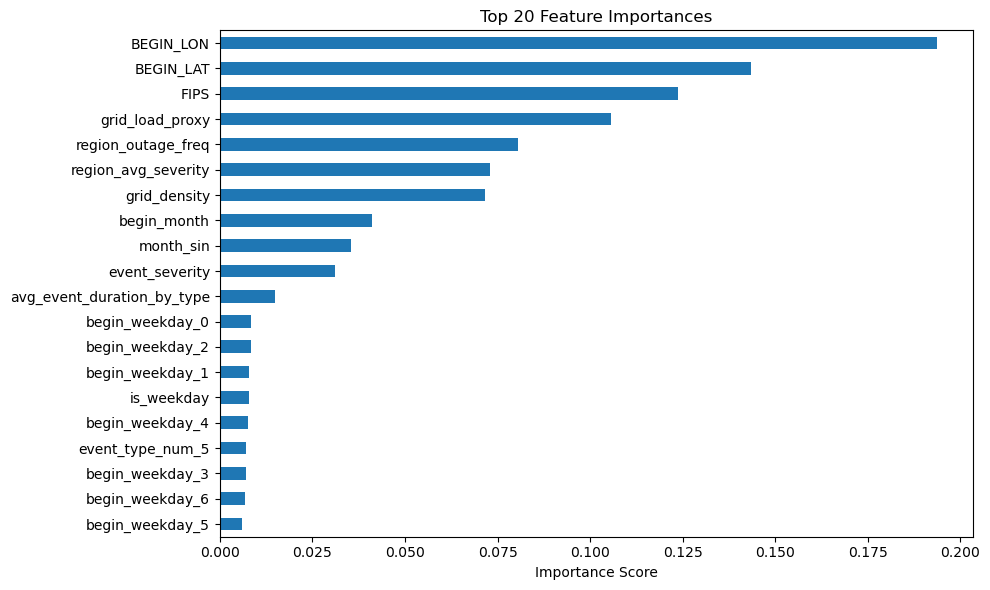

In [34]:
importances = model.feature_importances_
feature_names = X.columns

feature_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_series.head(20).plot(kind='barh')
plt.gca().invert_yaxis()  # top = most important
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [22]:
X_reg = X[df['outage_occurred'] == 1]
#y_reg = np.log1p(df.loc[df['outage_occurred'] == 1, 'customers_out'])
y_reg = (df.loc[df['outage_occurred'] == 1, 'customers_out'])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(Xr_train, yr_train)

# Predict
yr_pred = regressor.predict(Xr_test)

# Evaluate
rmse = mean_squared_error(yr_test, yr_pred, squared=False)
r2 = r2_score(yr_test, yr_pred)

print("RMSE: ", rmse)
print("R2: ", r2)

RMSE:  89057.85411303409
R2:  0.6882755978715822


In [32]:
# mae = mean_absolute_error(yr_test, yr_pred)
# mae
# df.info()
print(df['event_type_num'].value_counts())


event_type_num
9     14400
5      9398
2      5063
3      2587
7      1518
10     1320
8       403
4       362
0        54
1        10
Name: count, dtype: int64
